In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv("./creditcard.csv")

In [3]:
print(df.shape)           # 看有幾列幾欄
print(df.columns)         # 看有哪些欄位
# print(df.head())          # 頭五筆觀察欄位意義
# print(df.describe())      # 各欄統計數值
print(df['Class'].value_counts())  # 詐欺比例


(284807, 31)
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')
Class
0    284315
1       492
Name: count, dtype: int64


In [4]:
df.isnull().sum() # 檢查缺失值
print(df.duplicated().sum()) # 檢查重複資料
df = df.drop_duplicates() # 移除重複值
print(df.duplicated().sum()) # 檢查重複資料

1081
0


In [5]:
scaler = StandardScaler()
df['normAmount'] = scaler.fit_transform(df[['Amount']])
df['normTime'] = scaler.fit_transform(df[['Time']])

# 可移除原始欄位（避免重複）
df.drop(['Amount', 'Time'], axis=1, inplace=True)

In [6]:
fraud = df[df['Class'] == 1]
non_fraud = df[df['Class'] == 0].sample(n=len(fraud), random_state=42)
print(len(fraud))
balanced_df = pd.concat([fraud, non_fraud])
# print(balanced_df)
# 打亂順序
balanced_df = balanced_df.sample(frac=1, random_state=42)
# print(balanced_df)


473


In [7]:
X = balanced_df.drop('Class', axis=1)
y = balanced_df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
# print(X.info())
print(y)
# print(balanced_df.info())
print(balanced_df.columns.get_loc('Class')) # 查看Class在第幾欄

154697    1
8842      1
91708     0
233258    1
17317     1
         ..
41395     1
144108    1
36725     0
249239    1
33276     1
Name: Class, Length: 946, dtype: int64
28


In [8]:
model = LogisticRegression()
model.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


[[94  1]
 [ 6 89]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96        95
           1       0.99      0.94      0.96        95

    accuracy                           0.96       190
   macro avg       0.96      0.96      0.96       190
weighted avg       0.96      0.96      0.96       190

ROC AUC: 0.9836011080332411


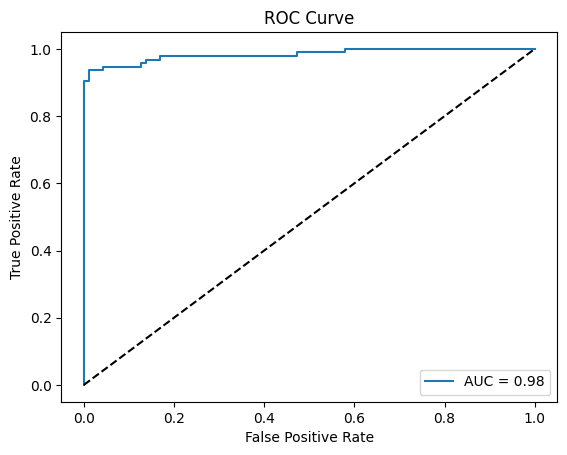

In [9]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]  # 機率值

# 混淆矩陣
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# AUC
auc = roc_auc_score(y_test, y_prob)
print("ROC AUC:", auc)

# 繪製 ROC 曲線
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [10]:
print(type(model))

<class 'sklearn.linear_model._logistic.LogisticRegression'>


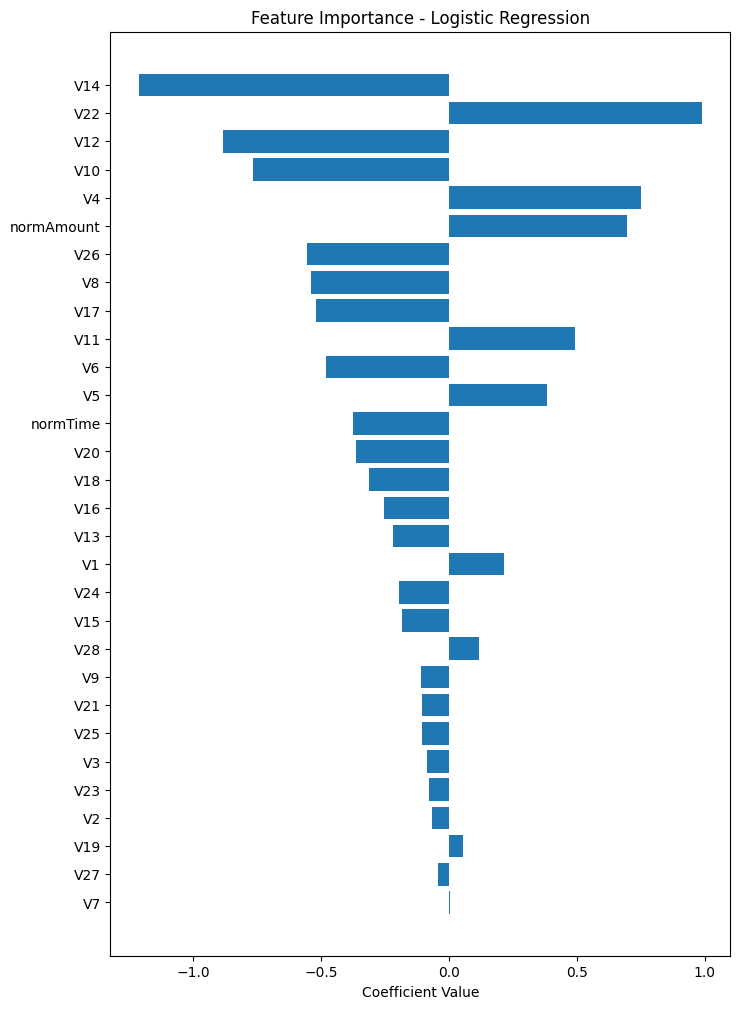

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# 假設 model 是已訓練的 LogisticRegression
# X 是訓練用特徵 DataFrame

coef = model.coef_[0]
features = X.columns

# 依係數絕對值排序
indices = np.argsort(np.abs(coef))

plt.figure(figsize=(8, 12))
plt.barh(features[indices], coef[indices])
plt.xlabel("Coefficient Value")
plt.title("Feature Importance - Logistic Regression")
plt.show()


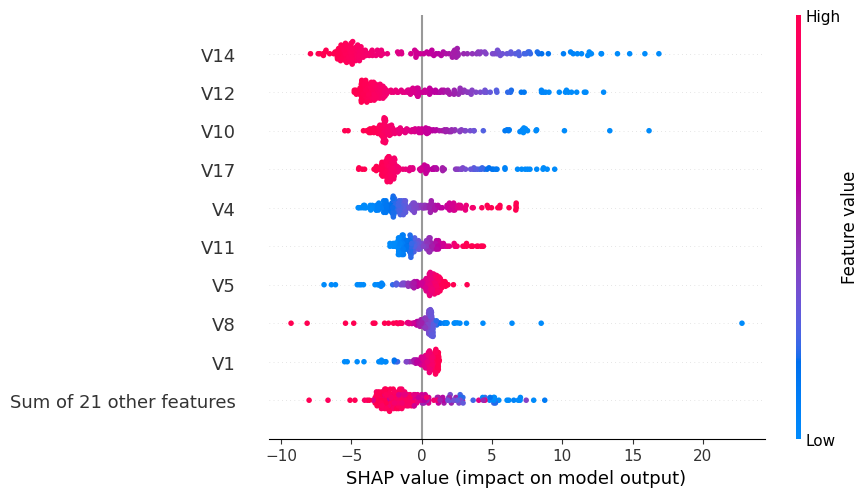

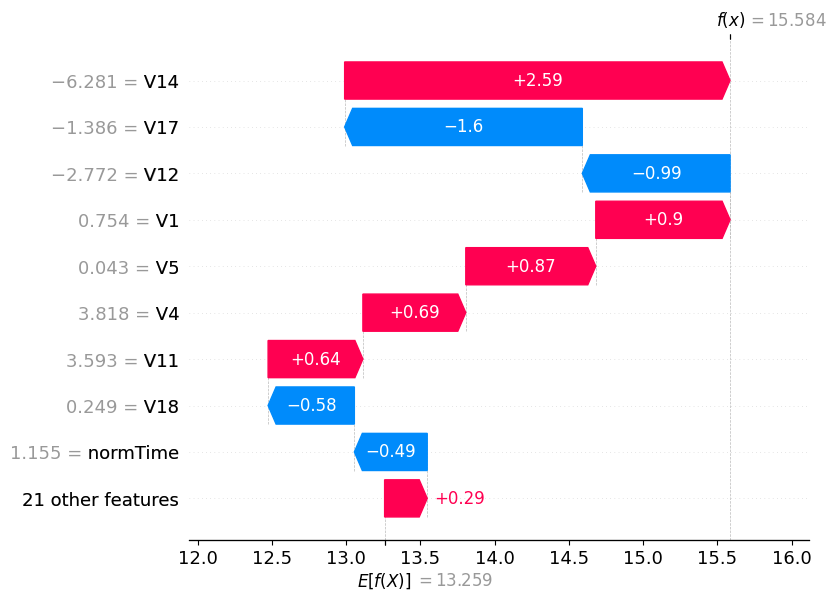

In [12]:
import shap
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)  # 全體趨勢
shap.plots.waterfall(shap_values[0])  # 單筆交易解釋


<Axes: xlabel='V14', ylabel='Density'>

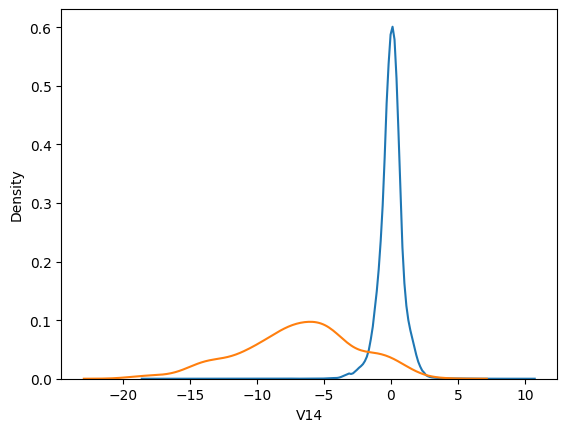

In [13]:
import seaborn as sns
sns.kdeplot(df[df['Class'] == 0]['V14'], label='Normal')
sns.kdeplot(df[df['Class'] == 1]['V14'], label='Fraud')
